In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader, random_split
from torch.optim import Adam
import torchaudio
import os
from tqdm import tqdm
import os
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import soundfile as sf

In [2]:
# ========== Dataset ========== #
class VocalSetDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list
        self.mel_transform = nn.Sequential(
            MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256, n_mels=80),
            AmplitudeToDB()
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.files[idx])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        mel = self.mel_transform(waveform)
        return mel.squeeze(0), waveform.squeeze(0)

# ========== Load Dataset ========== #
root_dir = 'VocalSet_processed'  # Update if needed

# Recursively get all .wav files from subdirectories
all_files = [
    os.path.join(root, f)
    for root, _, files in os.walk(root_dir)
    for f in files if f.endswith('.wav')
]

print("Total audio files found:", len(all_files))
if len(all_files) == 0:
    raise RuntimeError("No .wav files found. Please check the path and file extensions.")

dataset = VocalSetDataset(all_files)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

# ========== VQ-VAE Model ========== #
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(80, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, embedding_dim, kernel_size=4, stride=2, padding=1)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(embedding_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 80, kernel_size=4, stride=2, padding=1)
        )
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

    def forward(self, x):
        z_e = self.encoder(x)
        z_e_perm = z_e.permute(0, 2, 1)  # B x T x C
        distances = (
            torch.sum(z_e_perm ** 2, dim=2, keepdim=True)
            - 2 * torch.matmul(z_e_perm, self.codebook.weight.t())
            + torch.sum(self.codebook.weight ** 2, dim=1)
        )
        encoding_indices = torch.argmin(distances, dim=-1)
        z_q = self.codebook(encoding_indices)
        z_q = z_q.permute(0, 2, 1)  # B x C x T

        commitment_loss = F.mse_loss(z_e.detach(), z_q)
        codebook_loss = F.mse_loss(z_e, z_q.detach())
        loss = commitment_loss + codebook_loss

        x_recon = self.decoder(z_q)
        return x_recon, loss

# ========== Train ========== #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
recon_loss_fn = nn.MSELoss()

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for mel, _ in train_loader:
        mel = mel.to(device)
        mel = mel[:, :, :256]  # Ensure fixed size input
        x_recon, vq_loss = model(mel)
        
        # 🔧 Crop output to match input size
        min_len = min(x_recon.shape[2], mel.shape[2])
        x_recon = x_recon[:, :, :min_len]
        mel = mel[:, :, :min_len]

        recon_loss = recon_loss_fn(x_recon, mel)
        loss = recon_loss + vq_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f}")


# ========== Save Model ========== #
torch.save(model.state_dict(), 'vqvae_model.pth')
print("Model saved as vqvae_model.pth")

# ========== Generate Sample Reconstructions ========== #
model.eval()
os.makedirs("samples", exist_ok=True)
with torch.no_grad():
    for i in range(3):  # Save 3 examples
        mel, waveform = dataset[i]
        mel = mel.unsqueeze(0).to(device)
        mel = mel[:, :, :256]
        recon_mel, _ = model(mel)
        recon_mel = recon_mel.cpu().squeeze(0)

        inverse_mel = torchaudio.transforms.InverseMelScale(n_stft=513, n_mels=80, sample_rate=16000)(recon_mel)
        griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256)
        waveform_recon = griffin_lim(inverse_mel)

        sf.write(f"samples/original_{i}.wav", waveform[:waveform_recon.shape[-1]].numpy(), 16000)
        sf.write(f"samples/reconstructed_{i}.wav", waveform_recon.numpy(), 16000)
        print(f"Saved: samples/original_{i}.wav and samples/reconstructed_{i}.wav")


Total audio files found: 3613
Epoch 1/10 | Loss: 618283.0923
Epoch 2/10 | Loss: 473917.1042
Epoch 3/10 | Loss: 472727.5692
Epoch 4/10 | Loss: 471568.9315
Epoch 5/10 | Loss: 470609.7468
Epoch 6/10 | Loss: 469200.2812
Epoch 7/10 | Loss: 468357.2720
Epoch 8/10 | Loss: 466873.3768
Epoch 9/10 | Loss: 465593.8009
Epoch 10/10 | Loss: 464874.2840
Model saved as vqvae_model.pth
Saved: samples/original_0.wav and samples/reconstructed_0.wav
Saved: samples/original_1.wav and samples/reconstructed_1.wav
Saved: samples/original_2.wav and samples/reconstructed_2.wav


In [3]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import soundfile as sf
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

# ========== Dataset ========== #
class VocalSetDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list
        self.mel_transform = nn.Sequential(
            MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256, n_mels=80),
            AmplitudeToDB()
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.files[idx])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        mel = self.mel_transform(waveform)
        return mel.squeeze(0), waveform.squeeze(0)

# ========== Load Dataset ========== #
root_dir = 'VocalSet_processed'  # Update if needed

# Recursively get all .wav files from subdirectories
all_files = [
    os.path.join(root, f)
    for root, _, files in os.walk(root_dir)
    for f in files if f.endswith('.wav')
]

print("Total audio files found:", len(all_files))
if len(all_files) == 0:
    raise RuntimeError("No .wav files found. Please check the path and file extensions.")

dataset = VocalSetDataset(all_files)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

# ========== VQ-VAE Model ========== #
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(80, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, embedding_dim, kernel_size=4, stride=2, padding=1)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(embedding_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 80, kernel_size=4, stride=2, padding=1)
        )
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

    def forward(self, x):
        z_e = self.encoder(x)
        z_e_perm = z_e.permute(0, 2, 1)  # B x T x C
        distances = (
            torch.sum(z_e_perm ** 2, dim=2, keepdim=True)
            - 2 * torch.matmul(z_e_perm, self.codebook.weight.t())
            + torch.sum(self.codebook.weight ** 2, dim=1)
        )
        encoding_indices = torch.argmin(distances, dim=-1)
        z_q = self.codebook(encoding_indices)
        z_q = z_q.permute(0, 2, 1)  # B x C x T

        commitment_loss = F.mse_loss(z_e.detach(), z_q)
        codebook_loss = F.mse_loss(z_e, z_q.detach())
        loss = commitment_loss + codebook_loss

        x_recon = self.decoder(z_q)
        return x_recon, loss

# ========== Train ========== #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
recon_loss_fn = nn.MSELoss()

# ========== Learning Rate Scheduler ========== #
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decay the LR every 5 epochs

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for mel, _ in train_loader:
        mel = mel.to(device)
        mel = mel[:, :, :256]  # Ensure fixed size input
        x_recon, vq_loss = model(mel)
        
        # 🔧 Crop output to match input size
        min_len = min(x_recon.shape[2], mel.shape[2])
        x_recon = x_recon[:, :, :min_len]
        mel = mel[:, :, :min_len]

        recon_loss = recon_loss_fn(x_recon, mel)
        loss = recon_loss + vq_loss
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Step the learning rate scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# ========== Save Model ========== #
torch.save(model.state_dict(), 'vqvae_model.pth')
print("Model saved as vqvae_model.pth")

# ========== Generate Sample Reconstructions ========== #
model.eval()
os.makedirs("samples", exist_ok=True)
with torch.no_grad():
    for i in range(3):  # Save 3 examples
        mel, waveform = dataset[i]
        mel = mel.unsqueeze(0).to(device)
        mel = mel[:, :, :256]
        recon_mel, _ = model(mel)
        recon_mel = recon_mel.cpu().squeeze(0)

        inverse_mel = torchaudio.transforms.InverseMelScale(n_stft=513, n_mels=80, sample_rate=16000)(recon_mel)
        griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256)
        waveform_recon = griffin_lim(inverse_mel)

        sf.write(f"samples/original_{i}.wav", waveform[:waveform_recon.shape[-1]].numpy(), 16000)
        sf.write(f"samples/reconstructed_{i}.wav", waveform_recon.numpy(), 16000)
        print(f"Saved: samples/original_{i}.wav and samples/reconstructed_{i}.wav")


Total audio files found: 3613
Epoch 1/10 | Loss: 614954.0660 | LR: 0.000200
Epoch 2/10 | Loss: 470176.4475 | LR: 0.000200
Epoch 3/10 | Loss: 468976.4622 | LR: 0.000200
Epoch 4/10 | Loss: 467512.8056 | LR: 0.000200
Epoch 5/10 | Loss: 466053.8285 | LR: 0.000100
Epoch 6/10 | Loss: 464731.0772 | LR: 0.000100
Epoch 7/10 | Loss: 464088.2267 | LR: 0.000100
Epoch 8/10 | Loss: 463668.0990 | LR: 0.000100
Epoch 9/10 | Loss: 463077.5611 | LR: 0.000100
Epoch 10/10 | Loss: 462624.0186 | LR: 0.000050
Model saved as vqvae_model.pth
Saved: samples/original_0.wav and samples/reconstructed_0.wav
Saved: samples/original_1.wav and samples/reconstructed_1.wav
Saved: samples/original_2.wav and samples/reconstructed_2.wav


In [1]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import soundfile as sf
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

# ========== Dataset ========== #
class VocalSetDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list
        self.mel_transform = nn.Sequential(
            MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256, n_mels=80),
            AmplitudeToDB()
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.files[idx])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        mel = self.mel_transform(waveform)
        return mel.squeeze(0), waveform.squeeze(0)

# ========== Load Dataset ========== #
root_dir = 'VocalSet_processed'  # Update if needed

# Recursively get all .wav files from subdirectories
all_files = [
    os.path.join(root, f)
    for root, _, files in os.walk(root_dir)
    for f in files if f.endswith('.wav')
]

print("Total audio files found:", len(all_files))
if len(all_files) == 0:
    raise RuntimeError("No .wav files found. Please check the path and file extensions.")

dataset = VocalSetDataset(all_files)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

# ========== VQ-VAE Model ========== #
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(80, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(128, embedding_dim, kernel_size=4, stride=2, padding=1)
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(embedding_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 80, kernel_size=4, stride=2, padding=1)
        )
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

    def forward(self, x):
        z_e = self.encoder(x)
        z_e_perm = z_e.permute(0, 2, 1)  # B x T x C
        distances = (
            torch.sum(z_e_perm ** 2, dim=2, keepdim=True)
            - 2 * torch.matmul(z_e_perm, self.codebook.weight.t())
            + torch.sum(self.codebook.weight ** 2, dim=1)
        )
        encoding_indices = torch.argmin(distances, dim=-1)
        z_q = self.codebook(encoding_indices)
        z_q = z_q.permute(0, 2, 1)  # B x C x T

        commitment_loss = F.mse_loss(z_e.detach(), z_q)
        codebook_loss = F.mse_loss(z_e, z_q.detach())
        loss = commitment_loss + codebook_loss

        x_recon = self.decoder(z_q)
        return x_recon, loss

# ========== Train ========== #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
recon_loss_fn = nn.MSELoss()

# ========== Learning Rate Scheduler ========== #
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Decay the LR every 5 epochs

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for mel, _ in train_loader:
        mel = mel.to(device)
        mel = mel[:, :, :256]  # Ensure fixed size input
        x_recon, vq_loss = model(mel)
        
        # 🔧 Crop output to match input size
        min_len = min(x_recon.shape[2], mel.shape[2])
        x_recon = x_recon[:, :, :min_len]
        mel = mel[:, :, :min_len]

        recon_loss = recon_loss_fn(x_recon, mel)
        loss = recon_loss + vq_loss
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()

    # Step the learning rate scheduler
    scheduler.step()

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {total_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# ========== Save Model ========== #
torch.save(model.state_dict(), 'vqvae_model.pth')
print("Model saved as vqvae_model.pth")

# ========== Generate Sample Reconstructions ========== #
model.eval()
os.makedirs("samples", exist_ok=True)
with torch.no_grad():
    for i in range(3):  # Save 3 examples
        mel, waveform = dataset[i]
        mel = mel.unsqueeze(0).to(device)
        mel = mel[:, :, :256]
        recon_mel, _ = model(mel)
        recon_mel = recon_mel.cpu().squeeze(0)

        inverse_mel = torchaudio.transforms.InverseMelScale(n_stft=513, n_mels=80, sample_rate=16000)(recon_mel)
        griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256)
        waveform_recon = griffin_lim(inverse_mel)

        sf.write(f"samples/original_{i}.wav", waveform[:waveform_recon.shape[-1]].numpy(), 16000)
        sf.write(f"samples/reconstructed_{i}.wav", waveform_recon.numpy(), 16000)
        print(f"Saved: samples/original_{i}.wav and samples/reconstructed_{i}.wav")


Total audio files found: 3613
Epoch 1/10 | Loss: 665700.0164 | LR: 0.000200
Epoch 2/10 | Loss: 475022.6128 | LR: 0.000200
Epoch 3/10 | Loss: 473760.9290 | LR: 0.000200
Epoch 4/10 | Loss: 472314.9242 | LR: 0.000200
Epoch 5/10 | Loss: 470998.4531 | LR: 0.000100
Epoch 6/10 | Loss: 469297.7219 | LR: 0.000100
Epoch 7/10 | Loss: 468669.4342 | LR: 0.000100
Epoch 8/10 | Loss: 468130.3535 | LR: 0.000100
Epoch 9/10 | Loss: 467482.3655 | LR: 0.000100
Epoch 10/10 | Loss: 467001.5427 | LR: 0.000050
Model saved as vqvae_model.pth
Saved: samples/original_0.wav and samples/reconstructed_0.wav
Saved: samples/original_1.wav and samples/reconstructed_1.wav
Saved: samples/original_2.wav and samples/reconstructed_2.wav


In [6]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import soundfile as sf
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

# ========== Dataset ========== #
class VocalSetDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list
        self.mel_transform = nn.Sequential(
            MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256, n_mels=80),
            AmplitudeToDB()
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.files[idx])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        mel = self.mel_transform(waveform)
        mel = mel.mean(dim=0, keepdim=True)  # Convert to mono
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)  # Normalize
        return mel.squeeze(0), waveform.squeeze(0)

# ========== Load Dataset ========== #
root_dir = 'VocalSet_processed'
all_files = [
    os.path.join(root, f)
    for root, _, files in os.walk(root_dir)
    for f in files if f.endswith('.wav')
]

print("Total audio files found:", len(all_files))
if len(all_files) == 0:
    raise RuntimeError("No .wav files found. Please check the path and file extensions.")

dataset = VocalSetDataset(all_files)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

# ========== VQ-VAE Model ========== #
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(80, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, embedding_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU()
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(embedding_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 80, kernel_size=4, stride=2, padding=1)
        )
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

    def forward(self, x):
        z_e = self.encoder(x)  # B x C x T
        z_e_perm = z_e.permute(0, 2, 1)  # B x T x C
        distances = (
            torch.sum(z_e_perm ** 2, dim=2, keepdim=True)
            - 2 * torch.matmul(z_e_perm, self.codebook.weight.t())
            + torch.sum(self.codebook.weight ** 2, dim=1)
        )
        encoding_indices = torch.argmin(distances, dim=-1)  # B x T
        z_q = self.codebook(encoding_indices)  # B x T x C
        z_q = z_q.permute(0, 2, 1)  # B x C x T

        commitment_loss = F.mse_loss(z_e.detach(), z_q)
        codebook_loss = F.mse_loss(z_e, z_q.detach())

        x_recon = self.decoder(z_q)
        return x_recon, codebook_loss, commitment_loss

# ========== Training Setup ========== #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
recon_loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 50
beta = 0.25  # commitment weight

# ========== Training Loop ========== #
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for mel, _ in train_loader:
        mel = mel.to(device)
        mel = mel[:, :, :256]  # Optional: Ensure fixed input size
        x_recon, codebook_loss, commitment_loss = model(mel)

        # Ensure same length between prediction and ground truth
        min_len = min(x_recon.size(2), mel.size(2))
        x_recon = x_recon[:, :, :min_len]
        mel = mel[:, :, :min_len]

        loss_recon = recon_loss_fn(x_recon, mel)
        loss = loss_recon + codebook_loss + beta * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

    scheduler.step()

    # === Validation ===
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for mel, _ in val_loader:
            mel = mel.to(device)
            mel = mel[:, :, :256]
            x_recon, codebook_loss, commitment_loss = model(mel)

            # Match dimensions
            min_len = min(x_recon.size(2), mel.size(2))
            x_recon = x_recon[:, :, :min_len]
            mel = mel[:, :, :min_len]

            loss_recon = recon_loss_fn(x_recon, mel)
            loss = loss_recon + codebook_loss + beta * commitment_loss
            total_val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_train_loss:.4f} | Val Loss: {total_val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# ========== Save Model ========== #
torch.save(model.state_dict(), 'vqvae_model.pth')
print("Model saved as vqvae_model.pth")

# ========== Generate Sample Reconstructions ========== #
model.eval()
os.makedirs("samples", exist_ok=True)
with torch.no_grad():
    for i in range(3):  # Save 3 examples
        mel, waveform = dataset[i]
        mel = mel.unsqueeze(0).to(device)
        mel = mel[:, :, :256]
        recon_mel, _, _ = model(mel)
        recon_mel = recon_mel.cpu().squeeze(0)

        # Convert back to waveform
        inverse_mel = torchaudio.transforms.InverseMelScale(n_stft=513, n_mels=80, sample_rate=16000)(recon_mel)
        griffin_lim = torchaudio.transforms.GriffinLim(n_fft=1024, hop_length=256)
        waveform_recon = griffin_lim(inverse_mel)
        waveform_recon = waveform_recon.clamp(-1.0, 1.0)

        sf.write(f"samples/original_{i}.wav", waveform[:waveform_recon.shape[-1]].numpy(), 16000)
        sf.write(f"samples/reconstructed_{i}.wav", waveform_recon.numpy(), 16000)
        print(f"Saved: samples/original_{i}.wav and samples/reconstructed_{i}.wav")



Total audio files found: 3613
Epoch 1/50 | Train Loss: 225.0724 | Val Loss: 20.2659 | LR: 0.000200
Epoch 2/50 | Train Loss: 176.2235 | Val Loss: 18.7323 | LR: 0.000200
Epoch 3/50 | Train Loss: 164.5777 | Val Loss: 17.6183 | LR: 0.000200
Epoch 4/50 | Train Loss: 155.6207 | Val Loss: 16.8075 | LR: 0.000200
Epoch 5/50 | Train Loss: 148.9674 | Val Loss: 16.1901 | LR: 0.000100
Epoch 6/50 | Train Loss: 144.2535 | Val Loss: 15.8508 | LR: 0.000100
Epoch 7/50 | Train Loss: 142.2986 | Val Loss: 15.6460 | LR: 0.000100
Epoch 8/50 | Train Loss: 140.3610 | Val Loss: 15.4878 | LR: 0.000100
Epoch 9/50 | Train Loss: 138.4984 | Val Loss: 15.2205 | LR: 0.000100
Epoch 10/50 | Train Loss: 136.6675 | Val Loss: 15.0556 | LR: 0.000050
Epoch 11/50 | Train Loss: 135.5017 | Val Loss: 14.9884 | LR: 0.000050
Epoch 12/50 | Train Loss: 134.9000 | Val Loss: 14.8529 | LR: 0.000050
Epoch 13/50 | Train Loss: 134.0537 | Val Loss: 14.7826 | LR: 0.000050
Epoch 14/50 | Train Loss: 132.9637 | Val Loss: 14.7070 | LR: 0.000050

In [7]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import soundfile as sf
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, Resample

# ========== Dataset ========== #
class VocalSetDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list
        self.mel_transform = nn.Sequential(
            MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256, n_mels=80),
            AmplitudeToDB()
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.files[idx])
        if sr != 16000:
            resample = Resample(orig_freq=sr, new_freq=16000)
            waveform = resample(waveform)
        waveform = waveform.mean(dim=0, keepdim=True)  # Ensure mono
        mel = self.mel_transform(waveform)
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)  # Normalize
        return mel.squeeze(0), waveform.squeeze(0)

# ========== Load Dataset ========== #
root_dir = 'VocalSet_processed'
all_files = [
    os.path.join(root, f)
    for root, _, files in os.walk(root_dir)
    for f in files if f.endswith('.wav')
]

print("Total audio files found:", len(all_files))
if len(all_files) == 0:
    raise RuntimeError("No .wav files found. Please check the path and file extensions.")

dataset = VocalSetDataset(all_files)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

# ========== VQ-VAE Model ========== #
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(80, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, embedding_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU()
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(embedding_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 80, kernel_size=4, stride=2, padding=1)
        )
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

    def forward(self, x):
        z_e = self.encoder(x)  # B x C x T
        z_e_perm = z_e.permute(0, 2, 1)  # B x T x C
        distances = (
            torch.sum(z_e_perm ** 2, dim=2, keepdim=True)
            - 2 * torch.matmul(z_e_perm, self.codebook.weight.t())
            + torch.sum(self.codebook.weight ** 2, dim=1)
        )
        encoding_indices = torch.argmin(distances, dim=-1)  # B x T
        z_q = self.codebook(encoding_indices)  # B x T x C
        z_q = z_q.permute(0, 2, 1)  # B x C x T

        commitment_loss = F.mse_loss(z_e.detach(), z_q)
        codebook_loss = F.mse_loss(z_e, z_q.detach())

        x_recon = self.decoder(z_q)
        return x_recon, codebook_loss, commitment_loss

# ========== Training Setup ========== #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
recon_loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 50
beta = 0.25  # commitment weight

# ========== Training Loop ========== #
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for mel, _ in train_loader:
        mel = mel.to(device)
        mel = mel[:, :, :256]  # Fixed input size
        x_recon, codebook_loss, commitment_loss = model(mel)

        min_len = min(x_recon.size(2), mel.size(2))
        x_recon = x_recon[:, :, :min_len]
        mel = mel[:, :, :min_len]

        loss_recon = recon_loss_fn(x_recon, mel)
        loss = loss_recon + codebook_loss + beta * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

    scheduler.step()

    # === Validation ===
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for mel, _ in val_loader:
            mel = mel.to(device)
            mel = mel[:, :, :256]
            x_recon, codebook_loss, commitment_loss = model(mel)

            min_len = min(x_recon.size(2), mel.size(2))
            x_recon = x_recon[:, :, :min_len]
            mel = mel[:, :, :min_len]

            loss_recon = recon_loss_fn(x_recon, mel)
            loss = loss_recon + codebook_loss + beta * commitment_loss
            total_val_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_train_loss:.4f} | Val Loss: {total_val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# ========== Save Model ========== #
torch.save(model.state_dict(), 'vqvae_model.pth')
print("Model saved as vqvae_model.pth")

# ========== Generate Sample Reconstructions ========== #
model.eval()
os.makedirs("samples", exist_ok=True)
with torch.no_grad():
    for i in range(3):
        mel, waveform = dataset[i]
        mel = mel.unsqueeze(0).to(device)
        mel = mel[:, :, :256]
        recon_mel, _, _ = model(mel)
        recon_mel = recon_mel.cpu().squeeze(0)

        # Inversion
        mel_to_linear = torchaudio.transforms.InverseMelScale(
            n_stft=513, n_mels=80, sample_rate=16000
        )(recon_mel)
        griffin_lim = torchaudio.transforms.GriffinLim(
            n_fft=1024, hop_length=256
        )
        waveform_recon = griffin_lim(mel_to_linear)
        waveform_recon = waveform_recon.clamp(-1.0, 1.0)

        sf.write(f"samples/original_{i}.wav", waveform[:waveform_recon.shape[-1]].numpy(), 16000)
        sf.write(f"samples/reconstructed_{i}.wav", waveform_recon.numpy(), 16000)
        print(f"Saved: samples/original_{i}.wav and samples/reconstructed_{i}.wav")


Total audio files found: 3613
Epoch 1/50 | Train Loss: 248.2712 | Val Loss: 24.4945 | LR: 0.000200
Epoch 2/50 | Train Loss: 214.2066 | Val Loss: 22.9923 | LR: 0.000200
Epoch 3/50 | Train Loss: 200.6677 | Val Loss: 21.6811 | LR: 0.000200
Epoch 4/50 | Train Loss: 190.4460 | Val Loss: 20.6584 | LR: 0.000200
Epoch 5/50 | Train Loss: 182.6101 | Val Loss: 19.8794 | LR: 0.000100
Epoch 6/50 | Train Loss: 177.9725 | Val Loss: 19.6814 | LR: 0.000100
Epoch 7/50 | Train Loss: 175.2751 | Val Loss: 19.3912 | LR: 0.000100
Epoch 8/50 | Train Loss: 173.0194 | Val Loss: 19.1428 | LR: 0.000100
Epoch 9/50 | Train Loss: 171.6965 | Val Loss: 18.9958 | LR: 0.000100
Epoch 10/50 | Train Loss: 170.2377 | Val Loss: 18.8369 | LR: 0.000050
Epoch 11/50 | Train Loss: 168.5857 | Val Loss: 18.8689 | LR: 0.000050
Epoch 12/50 | Train Loss: 167.9193 | Val Loss: 18.7181 | LR: 0.000050
Epoch 13/50 | Train Loss: 167.9771 | Val Loss: 18.6892 | LR: 0.000050
Epoch 14/50 | Train Loss: 167.4866 | Val Loss: 18.6538 | LR: 0.000050

Total audio files found: 3613
Epoch 1/50 | Train Loss: 237.6294 | Val Loss: 21.6938 | LR: 0.000200
Epoch 2/50 | Train Loss: 186.3624 | Val Loss: 20.2336 | LR: 0.000200
Epoch 3/50 | Train Loss: 182.3814 | Val Loss: 21.2779 | LR: 0.000200
Epoch 4/50 | Train Loss: 187.8439 | Val Loss: 20.7763 | LR: 0.000200
Epoch 5/50 | Train Loss: 182.6219 | Val Loss: 20.0683 | LR: 0.000100
Epoch 6/50 | Train Loss: 178.7849 | Val Loss: 19.8346 | LR: 0.000100
Epoch 7/50 | Train Loss: 176.2482 | Val Loss: 19.6164 | LR: 0.000100
Epoch 8/50 | Train Loss: 174.3202 | Val Loss: 19.3451 | LR: 0.000100
Epoch 9/50 | Train Loss: 172.5324 | Val Loss: 19.1432 | LR: 0.000100
Epoch 10/50 | Train Loss: 170.4913 | Val Loss: 18.9629 | LR: 0.000050
Epoch 11/50 | Train Loss: 168.9120 | Val Loss: 18.8438 | LR: 0.000050
Epoch 12/50 | Train Loss: 168.0362 | Val Loss: 18.7549 | LR: 0.000050
Epoch 13/50 | Train Loss: 167.4956 | Val Loss: 18.6359 | LR: 0.000050
Epoch 14/50 | Train Loss: 166.3033 | Val Loss: 18.5807 | LR: 0.000050

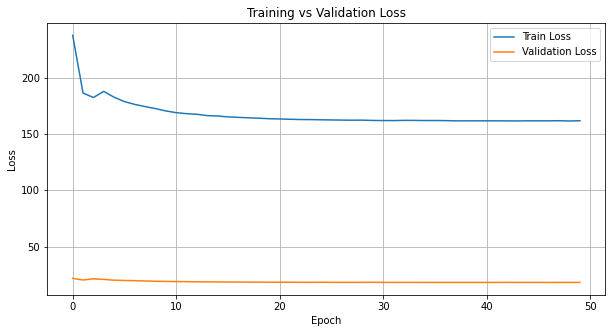

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

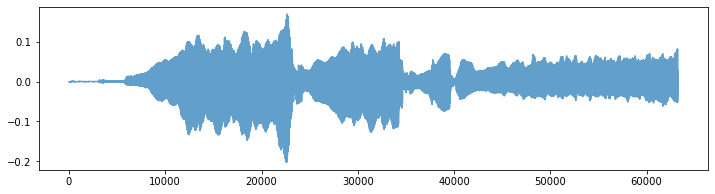

In [ ]:
import os
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import soundfile as sf
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import matplotlib.pyplot as plt
import numpy as np

# ========== Dataset ========== #
class VocalSetDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list
        self.mel_transform = nn.Sequential(
            MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=256, n_mels=80),
            AmplitudeToDB()
        )

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        waveform, sr = torchaudio.load(self.files[idx])
        if sr != 16000:
            waveform = torchaudio.functional.resample(waveform, sr, 16000)
        mel = self.mel_transform(waveform)
        mel = mel.mean(dim=0, keepdim=True)  # Convert to mono
        mel = (mel - mel.mean()) / (mel.std() + 1e-6)  # Normalize
        return mel.squeeze(0), waveform.squeeze(0)

# ========== Load Dataset ========== #
root_dir = 'VocalSet_processed'
all_files = [
    os.path.join(root, f)
    for root, _, files in os.walk(root_dir)
    for f in files if f.endswith('.wav')
]

print("Total audio files found:", len(all_files))
if len(all_files) == 0:
    raise RuntimeError("No .wav files found. Please check the path and file extensions.")

dataset = VocalSetDataset(all_files)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

# ========== VQ-VAE Model ========== #
class VQVAE(nn.Module):
    def __init__(self, num_embeddings=512, embedding_dim=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(80, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, embedding_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU()
        )
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(embedding_dim, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 80, kernel_size=4, stride=2, padding=1)
        )
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

    def forward(self, x):
        z_e = self.encoder(x)  # B x C x T
        z_e_perm = z_e.permute(0, 2, 1)  # B x T x C
        distances = (
            torch.sum(z_e_perm ** 2, dim=2, keepdim=True)
            - 2 * torch.matmul(z_e_perm, self.codebook.weight.t())
            + torch.sum(self.codebook.weight ** 2, dim=1)
        )
        encoding_indices = torch.argmin(distances, dim=-1)  # B x T
        z_q = self.codebook(encoding_indices)  # B x T x C
        z_q = z_q.permute(0, 2, 1)  # B x C x T

        commitment_loss = F.mse_loss(z_e.detach(), z_q)
        codebook_loss = F.mse_loss(z_e, z_q.detach())

        x_recon = self.decoder(z_q)
        return x_recon, codebook_loss, commitment_loss

# ========== Training Setup ========== #
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
recon_loss_fn = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

num_epochs = 50
beta = 0.25  # commitment weight

train_losses = []
val_losses = []

# ========== Training Loop ========== #
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for mel, _ in train_loader:
        mel = mel.to(device)
        mel = mel[:, :, :256]
        x_recon, codebook_loss, commitment_loss = model(mel)

        min_len = min(x_recon.size(2), mel.size(2))
        x_recon = x_recon[:, :, :min_len]
        mel = mel[:, :, :min_len]

        loss_recon = recon_loss_fn(x_recon, mel)
        loss = loss_recon + codebook_loss + beta * commitment_loss

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

    scheduler.step()

    # === Validation ===
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for mel, _ in val_loader:
            mel = mel.to(device)
            mel = mel[:, :, :256]
            x_recon, codebook_loss, commitment_loss = model(mel)

            min_len = min(x_recon.size(2), mel.size(2))
            x_recon = x_recon[:, :, :min_len]
            mel = mel[:, :, :min_len]

            loss_recon = recon_loss_fn(x_recon, mel)
            loss = loss_recon + codebook_loss + beta * commitment_loss
            total_val_loss += loss.item()

    train_losses.append(total_train_loss)
    val_losses.append(total_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {total_train_loss:.4f} | Val Loss: {total_val_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

# ========== Save Model ========== #
torch.save(model.state_dict(), 'vqvae_model.pth')
print("Model saved as vqvae_model.pth")

# ========== Plot Loss Curves ========== #
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid()
plt.savefig("loss_curve.png")
plt.show()


